# Homework 1 - K-Nearest Neighbor Classifier and Perceptron [ 100pts + 10 Bonus]
## CSCI 4622 - Fall 2022

Student name: here

Collaborators / sources:

This assignment is due on Canvas by **11:59PM on September 16th**.

Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc. Your solutions to analysis/theory questions should be done in Markdown directly below the associated question.

Remember that you are encouraged to discuss the problems with your classmates and instructors, but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from provided solutions to previous assignments.
***

In [1]:
import data
import helpers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import BallTree
from sklearn.metrics.pairwise import euclidean_distances


You will be guided through the different questions. You'll be expected to complete the classes and the functions following the provided signatures.

Remember to avoid adding positional arguments and make sure the returned values have the correct format (this applies to all assignments).
The alternative is that your solution might be rejected by the auto-grader (we won't be debugging your code during grading).
We will provide some basic sanity checks. They're in no means exhaustive and passing them does not imply that your solution is 100% correct.

For example, you're required to complete the method `compute_something` of class A.
We provide examples of acceptable solutions.

In [ ]:
# This cell can be removed from the submitted notebook
class A:
    def compute_something(self) -> np.ndarray:
        """
        :return: numpy array of zeros, with shape (4,)
        """
        # BEGIN
        answer = None
        # END
        return answer


class A1:  # Acceptable solution:
    # - the added y is an optional argument and omitting it does not affect the solution
    # - the returned object has the expected structure.
    def compute_something(self, y=None):
        # BEGIN
        return np.zeros((4,))
        # END


class A2:  # Wrong format:
    # - your solution requires a new positional argument y!: critical
    # - the returned object does not have the expected format!: critical
    # - solution outside the delimiters # BEGIN # END: makes grading easier
    def compute_something(self, y):
        return [0, 0, 0, 0]


class A3:  # Acceptable solution:
    # You're free to add your own helper functions/methods,
    # but they should be defined in the jupyter notebook (no external files)
    def compute_something(self):
        # BEGIN
        return self.get_zeros(4)
        # END

    def get_zeros(self, i):
        return np.zeros((i,))

# Problem 1: Intro to LaTeX [9 points]

Most homeworks in this course will require you to write solutions to at least one or two math-based exercises. This problem is designed to get you used to MathJax-LaTeX for typesetting math in Jupyter Notebooks.  [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is a markup language used for typesetting mathematical formulas and documents.  [MathJax](https://en.wikipedia.org/wiki/MathJax) is a LaTeX plug-in for Markdown that brings some LaTeX functionality to Jupyter. A good tutorial on MathJax can be found in this [StackExchange post](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference/5024).

Your goal is this problem is to use MathJax to reproduce a collection of formulas as accurately as possible. Note that because computing environments vary from person to person, you shouldn't worry about tiny details like matching fonts (though you should worry about normal vs italic vs bold).  Just do your best to get reasonably close.

**Q1.1** [3 points] Reproduce the expression shown below using MathJax:
<div>
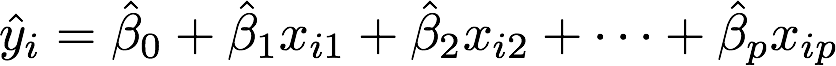
</div>

#### Workspace 1.1
#BEGIN

% YOUR ANSWER HERE

#END

**Q1.2** [3 points] Reproduce the expression shown below using MathJax:
<div>
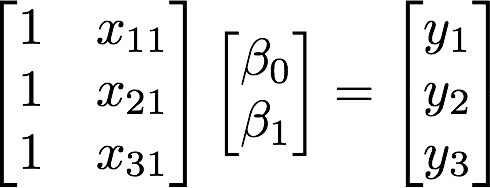
</div>

#### Workspace 1.2
#BEGIN

% YOUR ANSWER HERE

#END

**Q1.3** [3 points] Reproduce the expression shown below using MathJax:
<div>
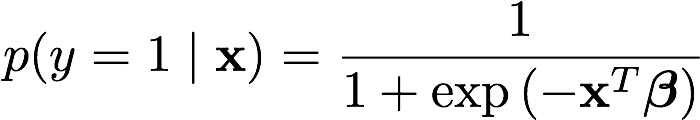
</div>

#### Workspace 1.3
#BEGIN

% YOUR ANSWER HERE

#END

***
For this assignment, we will be implementing our own K-Nearest Neighbors classifier (KNNClassifier) algorithm and a Perceptron.

Yes, we are not the first to implement KNN, or basically any algorithm we'll work with in this class. But with this method:
1. We'll know that you know what's really going on
2. You'll know you can do it
3. If someday you have to implement some machine learning algorithm from scratch, then you'll have the skill to tweak it to your need.


That said - we're not going to implement *everything*. We've already imported a few helper functions.

Let's also load a dataset to play with and start working to build out our own classifier.

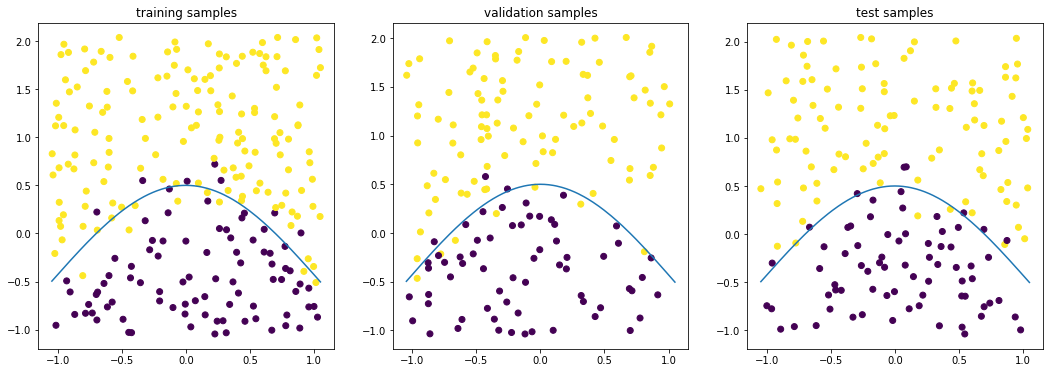

In [2]:
binary_data = data.BinaryData()
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
for i, name in enumerate(["training", "validation", "test"]):
    axs[i].plot(*binary_data.boundary())
    axs[i].set_title("%s samples" % name)
axs[0].scatter(binary_data.X_train[:, 0], binary_data.X_train[:, 1], c=binary_data.y_train)
axs[1].scatter(binary_data.X_valid[:, 0], binary_data.X_valid[:, 1], c=binary_data.y_valid)
axs[2].scatter(binary_data.X_test[:, 0], binary_data.X_test[:, 1], c=binary_data.y_test)
plt.show()

We have data! The `binary_data` is an instance of `data.Dataset`, which has the following attributes:
- a training set (`X_train, y_train`): to train the model and on which the prediction is based
- a validation set (`X_valid, y_valid`): to select the best __hyperparameters__ of the model
- a test set (`X_test, y_test`): to evaluate the performance of the model on unseen data


## Problem 2: KNN Classifier [ 34 points + 7]

The KNNClassifier class we're implementing will have similar design to the [KNeighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- A `fit` method that uses the training data
- A `predict` method that returns the predicted labels given data `X`

We've written out a lot of the structure for you for consistency across different parts of the assignment and so
you can focus on the "important" stuff that actually relates to machine learning itself.

**Q2.1** *[10 points]* Complete the `majority_vote` function to determine the majority class of a series of neighbors. If there is a tie, then you should remove the farthest element until the tie is broken.

For instance, if we're predicting the class label for two samples and for k=3, `majority_vote` will take two 2-d arrays with 2 rows (2 samples) and 3 columns (k): `k_nearest_indices` and `k_nearest_distances`. The first one (`k_nearest_indices`) is a matrix whose row $i$ consists of the indices of the 3 nearest neighbors to sample $i$ from X_train, while `k_nearest_distances[i]` will be their corresponding distances from sample $i$. `k_nearest_indices` and `k_nearest_distances` are provided by the `predict` method
<br>

**Q2.2** [5 points] Complete the `predict` function to capture the predicted class of a new datapoint
    - HINT: Use the [BallTree documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) to determine how to retrieve neighbors from the training samples. Note that BallTree returns the indices of nearest neighbors in order of ascending distances

**Q2.3** [5 points] Complete the `confusion_matrix` function to reveal the results of classification. You're not allowed to use scikit-learn's `confusion_matrix`


**Q2.4** [5 points] Complete the `accuracy` function to get accuracy of the classifier based on a given test data. You're not allowed to use scikit-learn's `accuracy_score`

In [ ]:
class KNNClassifier:

    def __init__(self, k=5):
        """
        Initialize our custom KNN classifier
        :param k: the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._ball_tree = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None

    def fit(self, X, y):
        """ Fit the model using the provided data
        Args:
            X:  matrix of shape (num_training_samples, num_features)
            y: array of shape (num_training_samples,)
        Returns: Fit instance of KNNClassifier (self)
        """
        self._ball_tree = BallTree(X)  # See documentation of BallTree and how it's used
        self._y = y
        # The following attributes should be used to map the classes to {0,1,..C-1} if needed (C is the number of classes)
        # Example, if labels are in {1,4,5}, then their indices are, respectively: {0, 1, 2} = label_to_index({1, 3, 5})
        # This is useful later in confusion_matrix
        # We can assume that the training data contains samples from all the possible classes
        classes = np.unique(y)
        self.label_to_index = dict(zip(classes, range(classes.shape[0])))
        self.index_to_label = dict(zip(range(classes.shape[0]), classes))

        return self

    def label_of_training_sample(self, index):
        # helper method to get labels fo indices in majority_vote
        assert index < self._y.shape[0]
        return self._y[index]

    def majority_vote(self, k_nearest_indices, k_nearest_distances=None):
        """ Given indices of the nearest k neighbors for each point,
            report the majority label of those points.
        Args:
            k_nearest_indices: 2-d array of the indices of training neighbors, of shape (M, k)
            k_nearest_distances: 2-d array of the corresponding distances of training neighbors, of shape (M, k)
        Returns: The majority label for each row of indices, shape (M,)
        """
        # Workspace 2.1
        # TODO: Determine majority for each row of k_nearest_indices
        # TODO: if there is a tie, remove the farthest neighbor until the tie is broken
        #BEGIN 
        # code here
        #END
        return voted_labels

    def predict(self, X):
        """ Given new data points, classify them according to the training data provided in self.fit 
            and number of neighbors self.k. You should use BallTree to get the distances and indices 
            of the nearest k neighbors
        Args:
            X: feature vectors (num_samples, num_features)
        Returns:
            1-D array of predicted classes of shape (num_samples,)
        """
        # Workspace 2.2
        #BEGIN 
        # code here
        #END
        return self.majority_vote(indices_k_nearest, distances_k_nearest)

    def confusion_matrix(self, X, y):
        """ Generate the confusion matrix for the given data
        Args:
            X: data matrix, shape (num_samples, num_features)
            y: the corresponding correct classes of our set, shape (num_samples,)
        Returns: a CxC matrix, where C is the number of classes in our training data
        """
        # The rows of the confusion matrix correspond to the true labels, the columns to the predictions'
        # Workspace 2.3
        # TODO: Run prediction for the test set X, compare to test answers y, and add counts to matrix
        # Hint: Use self.label_to_index to map the labels to indices of rows/columns of the confusion matrix
        c_matrix = np.zeros((len(self.label_to_index), len(self.label_to_index)))
        #BEGIN 
        # code here
        #END
        return c_matrix

    def accuracy(self, X, y):
        """ Return the accuracy of the classifier on the data (X, y)
        Args:
            X: matrix of shape (num_samples, num_features)
            y: array of shape (num_samples,)

        Returns: accuracy score [float in (0,1)]
        """
        # Workspace 2.4
        # TODO: Compute accuracy on X
        #BEGIN 
        # code here
        #END
        return score

In [ ]:
# Test cell, uncomment to run the tests
%run -i tests knn

The next cell shows the decision surface of the classifier. You can change k to visualize KNN behavior.

In [ ]:
knn = KNNClassifier(2).fit(binary_data.X_train, binary_data.y_train)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
helpers.show_decision_surface(knn, binary_data.X_train, binary_data.y_train, axs[0])
helpers.show_decision_surface(knn, binary_data.X_valid, binary_data.y_valid, axs[1])
helpers.show_decision_surface(knn, binary_data.X_test, binary_data.y_test, axs[2])
plt.show()

**Q2.5** *[5 points]* For each k in the range [1,32], fit a KNNClassifier on the training set and plot the accuracies on training and validation
data versus k. What's the value of k that yields the best accuracy on the training set? on the validation set? Which one
 should we choose?

In [ ]:
%%time
# %%time computes and prints the duration to run the cell, it should be in the first line
# Workspace 2.5.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    #BEGIN 
    # code here
    #END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()

#### Workspace 2.5.b
% Write up: best k for training and validation and which one should we choose

#BEGIN

% YOUR ANSWER HERE

#END

**Q2.6** [4 points] Report the accuracy and the confusion matrix on the test set using the value of k chosen in 2.5 (use print)

In [ ]:
# Workspace 2.6
# TODO: compute and print the accuracy on the test set using k from 1.5
# inc best_k = None
#BEGIN 
# code here
#END

**[Bonus] Q2.7.a** [2 point] A [__consistent classifier__](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf) on the training data is defined as a classifier that reaches 100% accuracy on the training set. For which values of k is KNNClassifier consistent?

**[Bonus] Q2.7.b** [2 points] Go back and edit your `KNNClassifier` so that it's consistent for all $k$ (we made sure that the change does not affect the sanity checks, do not create a new KNNClassifier class to add consistency)

#### Write-up for the bonus
**Workspace 2.7.a**

% for which k in KNNClassifier consistent

#BEGIN

% YOUR ANSWER HERE

#END

- **[Bonus] Q2.8.a** [2 point]. In some scenarios the training set can be huge and querying all training samples becomes computationally expensive. One way to circumvent this issue is to condense our training data for KNNClassifier(k) using the following approach:
    - Pick a parameter k
    - Start from a random index i (we'll pick the first sample 0)
    - While i < size(training set)
        - Find the k nearest neighbors to i (excluding itself)
        - Drop sample i if the k nearest neighbors all have the same label as i, keep it otherwise
    - Return the condensed training data
Note that if sample $i$ is dropped, then it should not be included in the k nearest neighbors in the next iteration.

In [ ]:
def condense_data(X_train, y_train, num_neighbors=3):
    condensed_X, condensed_y = X_train.copy(), y_train.copy()
    # Workspace 2.8.a
    #BEGIN 
    # code here
    #END
    return condensed_X, condensed_y

- **[Bonus] Q2.8.b** [1 point] Re-run 2.5 and 2.6 using the condensed training set from binary_data for k = 2. Is it faster? Does it perform better than the previous run?

In [ ]:
# Workspace 2.8.b
#BEGIN 
# code here
#END


#### Q2.8.b Write-up
#BEGIN

% YOUR ANSWER HERE

#END

***
## Problem 3 - Identifying Digits from Images [19 points + 3]

OK - now we've demonstrated that our KNN classifier works, let's try another problem space!: Digits data

**Q3.1** [ 5 points] Complete `prepare_data` by reporting the number of examples in different partitions of the digits dataset and the number of pixels in the images. You also have to reshape `X_train, X_valid, X_test` arrays as matrices (2-d arrays) for our KNNClassifier to use them.

Note: the question is simple and straight-forward, there is no trick here,

In [3]:
digit_data = data.DigitData()

In [ ]:
def prepare_data(dataset: data.Dataset):
    """
    Report information about the dataset using the print() function and reshape X_? to 2-d arrays
    """
    #BEGIN 
    # code here
    #END

In [ ]:
prepare_data(digit_data)

You can examine some samples from `digit_data` as follows:

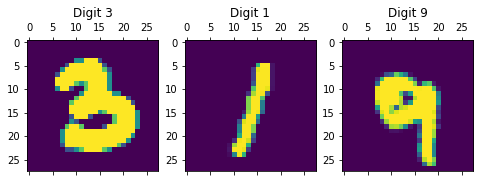

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(8, 24))
helpers.view_digit(digit_index=1,dataset = digit_data, partition="test", ax=ax[0])
helpers.view_digit(digit_index=5,dataset = digit_data, partition="test", ax=ax[1])
helpers.view_digit(digit_index=5,dataset = digit_data, partition="valid", ax=ax[2])
plt.show()

Now we want to automatically perform the model selection from 2.5, 2.6

**Q3.2** [8 points] complete the `evaluate` function to perform the same evaluation we did in 2.5/2.6:
- For k in range `ks_range`:
   - initialize the classifier for k  and train in on the training set
   - Compute the accuracy on the validation set and save it
- Choose k with the best accuracy on the validation set
- Report the accuracy and the confusion matrix on the **test** set (use `display_confusion` for a cleaner output)

In [ ]:
def evaluate(ks_range, dataset: data.Dataset):
    """ Evaluate KNNClassifier of Dataset for k in ks_range by printing the accuracy and confusion matrix of the best k
    Args:
        ks_range: range of k values
        dataset: dataset
    """
    # Workspace 3.2
    best_valid_k = None
    confusion_matrix = None
    accuracy = 0
    ks = ks_range
    accuracies_valid = []
    for k in ks:
        print(k, end="\r")
        #BEGIN 
        # code here
        #END
    print("best k:", best_valid_k)
    print("Accuracy on test set:", accuracy)
    helpers.display_confusion(confusion_matrix)


In the next cell, we run the evaluation on k in the range ${2...9}$.

In [ ]:
%%time
evaluate(range(2, 10), digit_data)



**Q3.3** [6 points] Determine which classes are most often confused (from our confusion matrix above).
Display examples (at least 3) of **misclassified test instances** and explain why the KNNClassifier might have missed them.

In [ ]:
# Workspace 3.3.a
#TODO: Print out problem class images
helpers.view_digit(digit_index=1,dataset = digit_data, partition="test")
#BEGIN 
# code here
#END

**Workspace 3.3.b**

TODO: Write description of mis-classification

#BEGIN

% YOUR ANSWER HERE

#END

**[Bonus] Q3.4** [3 points] Now we condense the training set of `digit_data` using k = 4. Compare the running time and performance to the ones obtained using the full training set (requires **Q.2.8**)

In [ ]:
# Un-comment to condense fi 2.8 was implemented
# digit_data.X_train, digit_data.y_train = condense_data(digit_data.X_train, digit_data.y_train, k=4)

In [ ]:
# Workspace 3.4.a
#BEGIN 
# code here
#END

#### Workspace 3.4.b - Write-up
#BEGIN

% YOUR ANSWER HERE

#END

## Problem 4 - Perceptron Learning Algorithm [38 points]

In this problem you will implement the Perceptron Learning Algorithm and use it to explore the convergence of the algorithm on linearly separable simulated data sets with particular properties.

Let's generate and plot a linearly separable dataset:

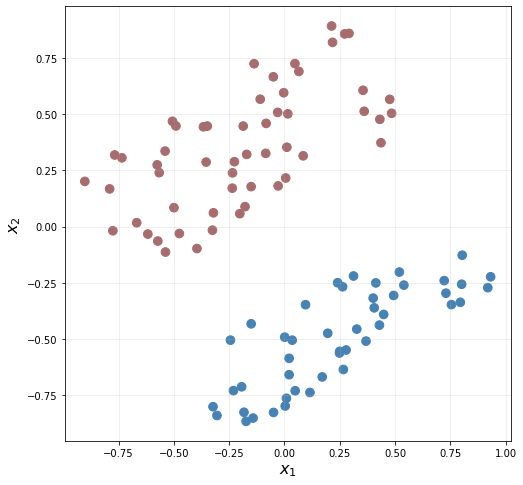

In [5]:
separable_data = data.SeparableData(num_samples=100, margin=0.2, random_seed=4622)
helpers.plot_data(separable_data.X_train, separable_data.y_train)

At this stage, `helpers.plot_data` does not have access to the correct decision boundary. To provide one, we build our own Perceptron.

Reminder: A perceptron is a binary classifier that learns a decision function of the form:
$$
f_{w,b}(\mathbf{x}) = \begin{cases}1 & \text{ if }\ \mathbf{w} \cdot \mathbf{x} + b > 0,\\0 & \text{ otherwise}\end{cases}
$$
where $\mathbf{w}\cdot\mathbf{x}$ is the dot product $\sum_i w_i x_i$ and $\mathbf{b}$ is the intercept.

For a more practical implementation, we want to incorporate the intercept into $\mathbf{w}$.

**Q 4.1** [5 points] Show that learning the decision function $f_{w,b}$ over $\text{R}^2$ is equivalent to learning a decision function $f_w$ through the origin ($b = 0$ ) over $C = \{\hat{x}\in\text{R}^3 | \hat{x}_3 = 1\}$


#### Workspace 4.1
#BEGIN

% YOUR ANSWER HERE

#END

**Q4.2** [6 points] Complete the method `fit` by looping through the data **once** and updating the weights `w` when $\mathbf{y} \mathbf{w}\cdot\mathbf{x} < 0$.

In our perceptron, a constant columns of ones is appended to our 2-d data in the `fit` and `predict` methods. Make sure to shuffle the data when `shuffle` is set to true and keep track of the number of mistakes.

In [ ]:
def sign(x):
    """ Return 1 if x >0, -1 otherwise
    Args:
        x: float or numpy array
    Returns: integer, same class as x
    """
    return 2 * (x > 0) - 1

class Perceptron:
    """
    Class to fit a perceptron classifier to simulated data
    """
    def __init__(self):
        self.w = np.ones(3)
        self.num_mistakes = 0

    def fit(self, X_train, y_train, shuffle=False):
        """ train the perceptron on the 2-d data
        Args:
            X_train: training features, shape (num_samples, 2)
            y_train: training labels in {-1, 1}, shape (num_samples,)
            shuffle: boolean, if true shuffle the data before training
        Returns: fit perceptron
        """
        # append constant column on 1s as the last column
        X_train = np.append(X_train, np.ones((len(X_train), 1)), 1)
        # initialize the weights and intercept
        self.w = 0.0 * self.w + 1.0
        self.num_mistakes = 0
        # Workspace 4.2
        #BEGIN 
        # code here
        #END
        return self
    def predict(self, X_eval):
        # append columns of 1 and return the predicted labels
        X_eval = np.append(X_eval, np.ones((len(X_eval), 1)), 1)
        return sign(X_eval.dot(self.w))

In [ ]:
%run -i tests perceptron

In [ ]:
perceptron = Perceptron()
perceptron.fit(separable_data.X_train, separable_data.y_train)
print("Accuracy:", np.mean(perceptron.predict(separable_data.X_train) == separable_data.y_train))

Now that we have learned the decision  boundary defined by the hyperplane $w_1 x_1 + w_2 x_2 + w_3 = 0$, we want to modify `plot_data` to plot the decision boundary.

**Q4.3** [5 points] Complete `plot_data` by computing `yplot` using `xplot` and `model.w`

Hint: $x_1$ is `x_plot` and $x_2$ is `y_plot`

In [ ]:
def plot_data(model: Perceptron, X, y):
    """
    Plots the simulated data.  Plots the learned decision boundary
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    colors = ["steelblue" if yi == -1 else "#a76c6e" for yi in y]
    ax.scatter(X[:, 0], X[:, 1], color=colors, s=75)
    x_plot = np.array([-1, 1])
    # Workspace 4.3
    #BEGIN 
    # code here
    #END
    ax.plot(x_plot, y_plot, color="black", lw=2)
    ax.grid(alpha=0.25)
    ax.set_xlabel(r"$x_1$", fontsize=16)
    ax.set_ylabel(r"$x_2$", fontsize=16)
    plt.show()


In [ ]:
plot_data(perceptron, separable_data.X_train, separable_data.y_train)

**Q4.4** [6 points] Do we get the same decision boundary when we shuffle the data? Use `plot_data` or compare weights to prove your answer.

You'll have to use the argument `shuffle` in `Perceptron.fit`

In [ ]:
# Workspace 4.4
#BEGIN 
# code here
#END

In lecture, we stated that the time it takes to train the Perceptron on a linearly separable training set is determined by the `margin` of the training data.
An important theorem for Perceptron training states that if you train a perceptron on linearly separable training data with margin $M > 0$ and each training point satisfies $\|{\bf x}\|_2 \leq 1$ then the Perceptron Training Algorithm will complete after making at most $1/M^2$ classification mistakes: so the theoretical bound is $min(1/M^2, n)$ where $n$ is the number of training samples.


**Q4.5** [12 points] In this last question you will empirically verify this theorem:
- Train 20 perceptrons on randomly generated linearly separable training sets of size $n=1000$ with margins of $M=0.5, 0.3 ... 0.001,$ (see below, be sure to use different random state of each training set).
- Compute the **average** number of mistakes for each margin (average of 20 runs)
- Produce a log-log plot with $1/M$ on the horizontal axis and average number of mistakes on the vertical axis.
- On the same set of axes, plot the theoretical upper bound on the number of training mistakes.



In [ ]:
margins = np.array([.001,.005, .01, .05, .1, .2, .3, .5])
n = 1000
average_mistakes = 0.0 * margins
for idx, margin in enumerate(margins):
#BEGIN 
# code here
#END

**Q4.6** [4 points] Compare the plots of the two bounds from **Q4.5**

#### Workspace 4.6
#BEGIN

% YOUR ANSWER HERE

#END